In [1]:
import os
import json
import csv
import pandas as pd
import random, string, re, collections
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Load data

## 1.1 Assign gender attributes to roles

In [19]:
male_roles = [
    'brother', 'father', 'daddy', 'dad', 'papa', 'father-in-law', 'grandfather', 
    'husband', 'son', 'boyfriend', 'fiancé'
]

female_roles = [
    'sister', 'mother', 'mummy', 'mamma', 'mommy', 'mom', 'mum', 'mama', 
    'daughter', 'mother-in-law', 'grandmother', 'wife', 'girlfriend', 'fiancée', 
    'housewife'
]

neutral_roles = [
    'professor', 'supervisor', 'instructor', 'student', 'coach', 'tutor', 'dean', 
    'graduate', 'partner', 'classmate', 'companion', 'buddy', 'roommate', 'coworker', 
    'boss', 'colleague', 'mentor', 'friend', 'stranger', 'foreigner', 'best friend', 'close friend', 
    'parents', 'cousin'
]

def categorize_role(role):
    if role in male_roles:
        return 'male'
    elif role in female_roles:
        return 'female'
    elif role in neutral_roles:
        return 'neutral'
    else:
        return 'unknown'

role_df['gender'] = role_df['role'].apply(categorize_role)

gender_aligned_words = {'mother': ['mother', 'mummy', 'mamma', 'mommy', 'mom', 'mum', 'mama','mother-in-law'],
                        'father': ['daddy', 'dad', 'papa', 'father-in-law'],
                        'boyfriend': ['husband', 'fiancé','boyfriend'],
                        'girlfriend':['wife', 'girlfriend', 'fiancée'],
                        'partner': ['partner'],
                        'parents':['parents'],
                        'sister':['sister'],
                        'brother':['brother']
                       }

gender_role_cate = {'mother': 'parent',
                    'father': 'parent',
                    'parents': 'parent',
                    'partner': 'partner',
                    'boyfriend': 'partner',
                    'girlfriend':'partner',
                    'sister':'sibling',
                    'brother':'sibling',    
}

def find_align_word(dataset_val):
    for domain, datasets in gender_aligned_words.items():
        if dataset_val in datasets:
            return domain
    return None

role_df['align_words'] = role_df['role'].apply(find_align_word)
role_df['gender_role_cate'] = role_df['align_words'].map(gender_role_cate)

In [20]:
'''SAVE GENDER ATTRIBUTES'''
# role_gender_path = "../data/final-final-role-cate.csv"
# role_df.to_csv(role_gender_path, index=False)

'SAVE GENDER ATTRIBUTES'

## 1.1 Load role and answers

In [21]:
role_df_path = "../data/final-final-role-cate.csv"
role_df = pd.read_csv(role_df_path)

In [3]:
role_df['merged_cate'].unique()

array(['family', 'other occupations', 'psychology', 'school', 'work',
       'politics', 'natural science', 'medicine', 'math', 'law',
       'history', 'eecs', 'econ', 'romantic', 'social', 'AI'],
      dtype=object)

In [17]:
role_df.columns

Index(['role', 'role cate', 'occupation cate', 'merged_cate',
       'N-gram Frequency (2018-2019)', 'mmlu', 'interpersonal', 'gender',
       'align_words', 'gender_role_cate'],
      dtype='object')

In [13]:
# Use OPT experiment data as an example in this notebook

experiment_result_path = "../data/mmlu_role_ans/opt_1.3b_result_full.csv"
ans_df = pd.read_csv(experiment_result_path)[['role', 'dataset', 'accuracy', 'role cate', 'occupation cate', 'merged_cate']]

In [24]:
ans_role_df = pd.merge(ans_df, role_df[['role', 'mmlu','interpersonal', 
                                        'gender', 'align_words', 'gender_role_cate']], 
                       how='left')

In [40]:
gender_df = ans_role_df[ans_role_df['gender'].isin(['neutral', 'male', 'female'])]
gender_df.shape

(710599, 11)

In [33]:
gender_df.columns

Index(['role', 'dataset', 'accuracy', 'role cate', 'occupation cate',
       'merged_cate', 'mmlu', 'interpersonal', 'gender', 'align_words',
       'gender_role_cate'],
      dtype='object')

# 2. Plot gender difference

In [57]:
def ensure_directory(file_name):
    """Ensure that the directory for the given file name exists. Create it if it does not."""
    dir_name = os.path.dirname(file_name)
    if not os.path.exists(dir_name) and dir_name:
        os.makedirs(dir_name)

## Figure 12 

In [58]:
def plot_gender_diff(data, file_name, xlim_lower, xlim_upper):
        
    ensure_directory(file_name)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5, 4))  
    
    # left plot
    hue_order = ['neutral', 'female', 'male']
    sns.barplot(data=data, x='accuracy', y='gender_role_cate', hue='gender', hue_order=hue_order, ax=axs[0])
    axs[0].set_xlabel('Accuracy')
    axs[0].set_ylabel('Role Category')
    axs[0].set_xlim(xlim_lower, xlim_upper)
    axs[0].grid(False)
    axs[0].legend(loc='lower right', fontsize='small')
    
    # right plot 
    sns.barplot(data=data, y='gender', x='accuracy', order=hue_order, ax=axs[1])
    axs[1].set_ylabel('Gender')
    axs[1].set_xlabel('Accuracy')
    axs[1].set_xlim(xlim_lower, xlim_upper)
    axs[1].grid(False)
    
    plt.tight_layout()
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

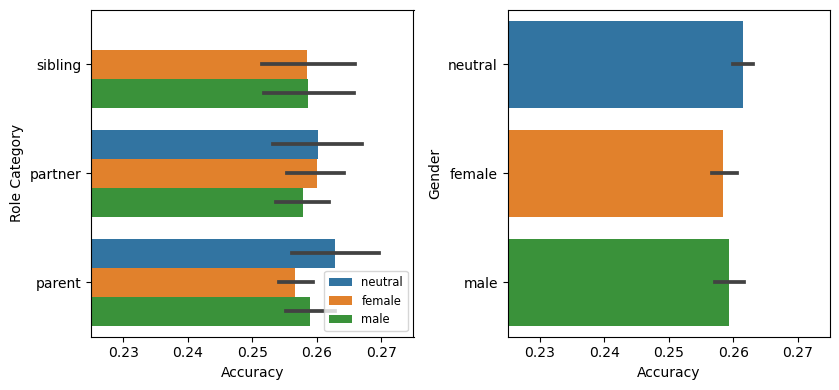

In [62]:
plot_gender_diff(data=gender_df,
                 file_name='../shared_data/figures/example/align_gender_12.pdf',
                 xlim_lower=0.225,
                 xlim_upper=0.275)

## Figure 13

In [60]:
domain_dic = {'law': ['professional_law', 'international_law'],
             'medicine': ['clinical_knowledge', 'college_medicine', 'professional_medicine'],
             'eecs': ['electrical_engineering', 'college_computer_science', 'high_school_computer_science'],
             'math': ['high_school_statistics', 'college_mathematics', 'high_school_mathematics'],
             'politics': ['us_foreign_policy', 'high_school_government_and_politics'],
             'psychology': ['professional_psychology', 'high_school_psychology'],
             'natural science': ['college_physics', 'college_biology', 'high_school_physics',
                                'high_school_chemistry', 'college_chemistry', 'high_school_biology'],
             'econ': ['management', 'professional_accounting', 'econometrics', 'high_school_macroeconomics', 'high_school_microeconomics']}

def find_domain(dataset_val):
    for domain, datasets in domain_dic.items():
        if dataset_val in datasets:
            return domain
    return None

In [68]:
def plot_gernder_by_domain(data, file_name, ylim_lower, ylim_upper):
    ensure_directory(file_name)
    
    data['domain'] = data['dataset'].apply(lambda x: find_domain(x))
    gender_role_dataset_mean = data.groupby(['role', 'gender', 'domain'])['accuracy'].mean().reset_index()
    order = gender_role_dataset_mean.groupby('domain')['accuracy'].mean().sort_values().reset_index()['domain']

    # Create the bar plot
    plt.figure(figsize=(7, 5))
    sns.barplot(data=gender_role_dataset_mean, x='domain', y='accuracy', hue='gender', order=order)

    # Setting labels and customizing axes
    plt.xlabel('Domain')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=20)
    plt.ylim(ylim_lower, ylim_upper)
    plt.grid(False)
    plt.legend(loc='upper left')

    # Save and show the plot
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_690457/1856841721.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['domain'] = data['dataset'].apply(lambda x: find_domain(x))


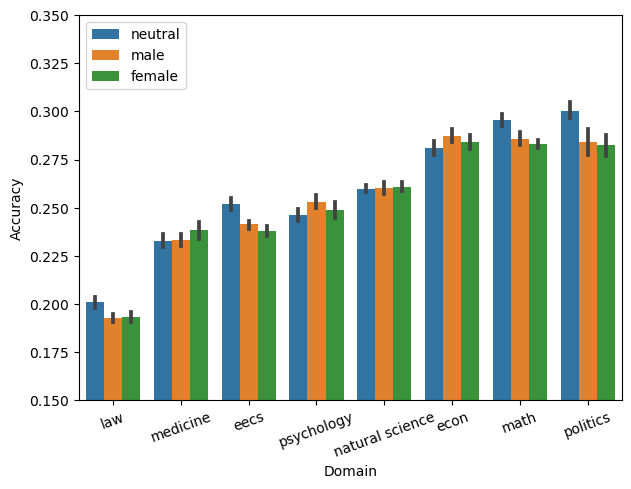

In [69]:
plot_gernder_by_domain(data=gender_df,
                       file_name='../shared_data/figures/example/gender_domain_13.pdf',
                       ylim_lower=0.15,
                       ylim_upper=0.35)